This script compute the SHAP value of largest CNN with the most data. The data used here to plot is run by cnn-SHAP.py. The first half is a repeat of the py file, the second half is load the shap value and analyze the boundaries. 

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct
import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pickle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
import importlib
import math
import keras
import random
import importlib
import MM_utilplot
import MM_util_AI
importlib.reload(MM_utilplot)
importlib.reload(MM_util_AI)
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
import matplotlib.colors as colors
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("Reduced_dim_variables"):
            rd_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]   
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]   
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]            
            
print(rd_path)
print(TMindex_path)
print(dim_path)
print(train_path)
print(models_path)
print(fig_path)

latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy')
lon_dict=dict(zip(np.arange(longitudes.size),longitudes))
lat_dict=dict(zip(np.arange(latitudes.size),latitudes))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector
def polorplot(ax,data_xr,max_abs,norm):
    im=xr.plot.contourf( 
        data_xr,
        x="longitude", y="latitude", ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',\
         add_colorbar=False,norm=norm,levels=np.linspace(-max_abs,max_abs,20)
    )
    gl=ax.gridlines(draw_labels=False)
    gl.ylocator = mticker.FixedLocator([20,50,60,70])  
    ax.coastlines()
    
    return ax,im

def polorplot_levels(plotmap,latitudes,longitudes ,minval,maxval,label="SHAP values", number_levels=30,iv=0.02):
    fig,ax = plt.subplots(figsize=(9,3), 
            subplot_kw={'projection': ccrs.NorthPolarStereo()},ncols=3)
    titles=["Z200","Z500","Z800"]
    max_abs=max(abs(minval),abs(maxval))
    norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    print("min plotmap=", plotmap.min() ,"max plotmap=", plotmap.max() ,)
    im_list=[]
    for i in range(3):
        y=plotmap[:,:,i]
        a = xr.DataArray(y, 
            coords={'latitude':latitudes,'longitude': longitudes,}, 
            dims=["latitude","longitude",])
        ax[i],im =polorplot( ax[i],a, max_abs=max_abs,norm=norm)
        im_list.append(im)
        ax[i].set_title(titles[i])
        
    cbar_ax = fig.add_axes([0.05, -0.1, .9, .05]) #left, bottom, width, height
    cbar = fig.colorbar(im_list[0],ax=ax, cax=cbar_ax, orientation="horizontal",cmap='coolwarm',\
                        ticks= np.arange(iv*int(-max_abs/iv)+iv,iv*int(max_abs/iv),iv),\
                        label = label, shrink = 1, fraction=0.046, pad=0.04) 
#     plt.subplots_adjust(wspace=0.1,width_ratios=[1,1,1])
    fig.tight_layout()
    return fig,ax
def add_sq(sq,ax):
    if sq:
        path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_%d/"%4
        color=["#000000", "#0072B2", "#009E73", "#D50000","#CC79A7"]
        boundary1_sq=np.load(path+"boundary1_sq.npy")
        boundary2_sq=np.load(path+"boundary2_sq.npy")
        boundary3_sq=np.load(path+"boundary3_sq.npy")
        boundary4_sq=np.load(path+"boundary4_sq.npy")
        for a in ax:
            a .plot(boundary1_sq[:,1],boundary1_sq[:,0],'-',color=color[0],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary2_sq[:,1],boundary2_sq[:,0],'-',color=color[1],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary3_sq[:,1],boundary3_sq[:,0],'-',color=color[2],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary4_sq[:,1],boundary4_sq[:,0],'-',color=color[3],alpha = 1,transform=ccrs.PlateCarree(),)
        return ax

/scratch/hz1994/blocking/data_MMmodel/reduceddim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


# Analyze the shap value data

min plotmap= -0.0008852500759177274 max plotmap= 0.003773272206906998


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


min plotmap= -0.00034153013334092884 max plotmap= 0.0017754289034558827
min plotmap= -11.543410955576842 max plotmap= 9.192036165119214
min plotmap= -11.543410955576842 max plotmap= 9.192036165119214


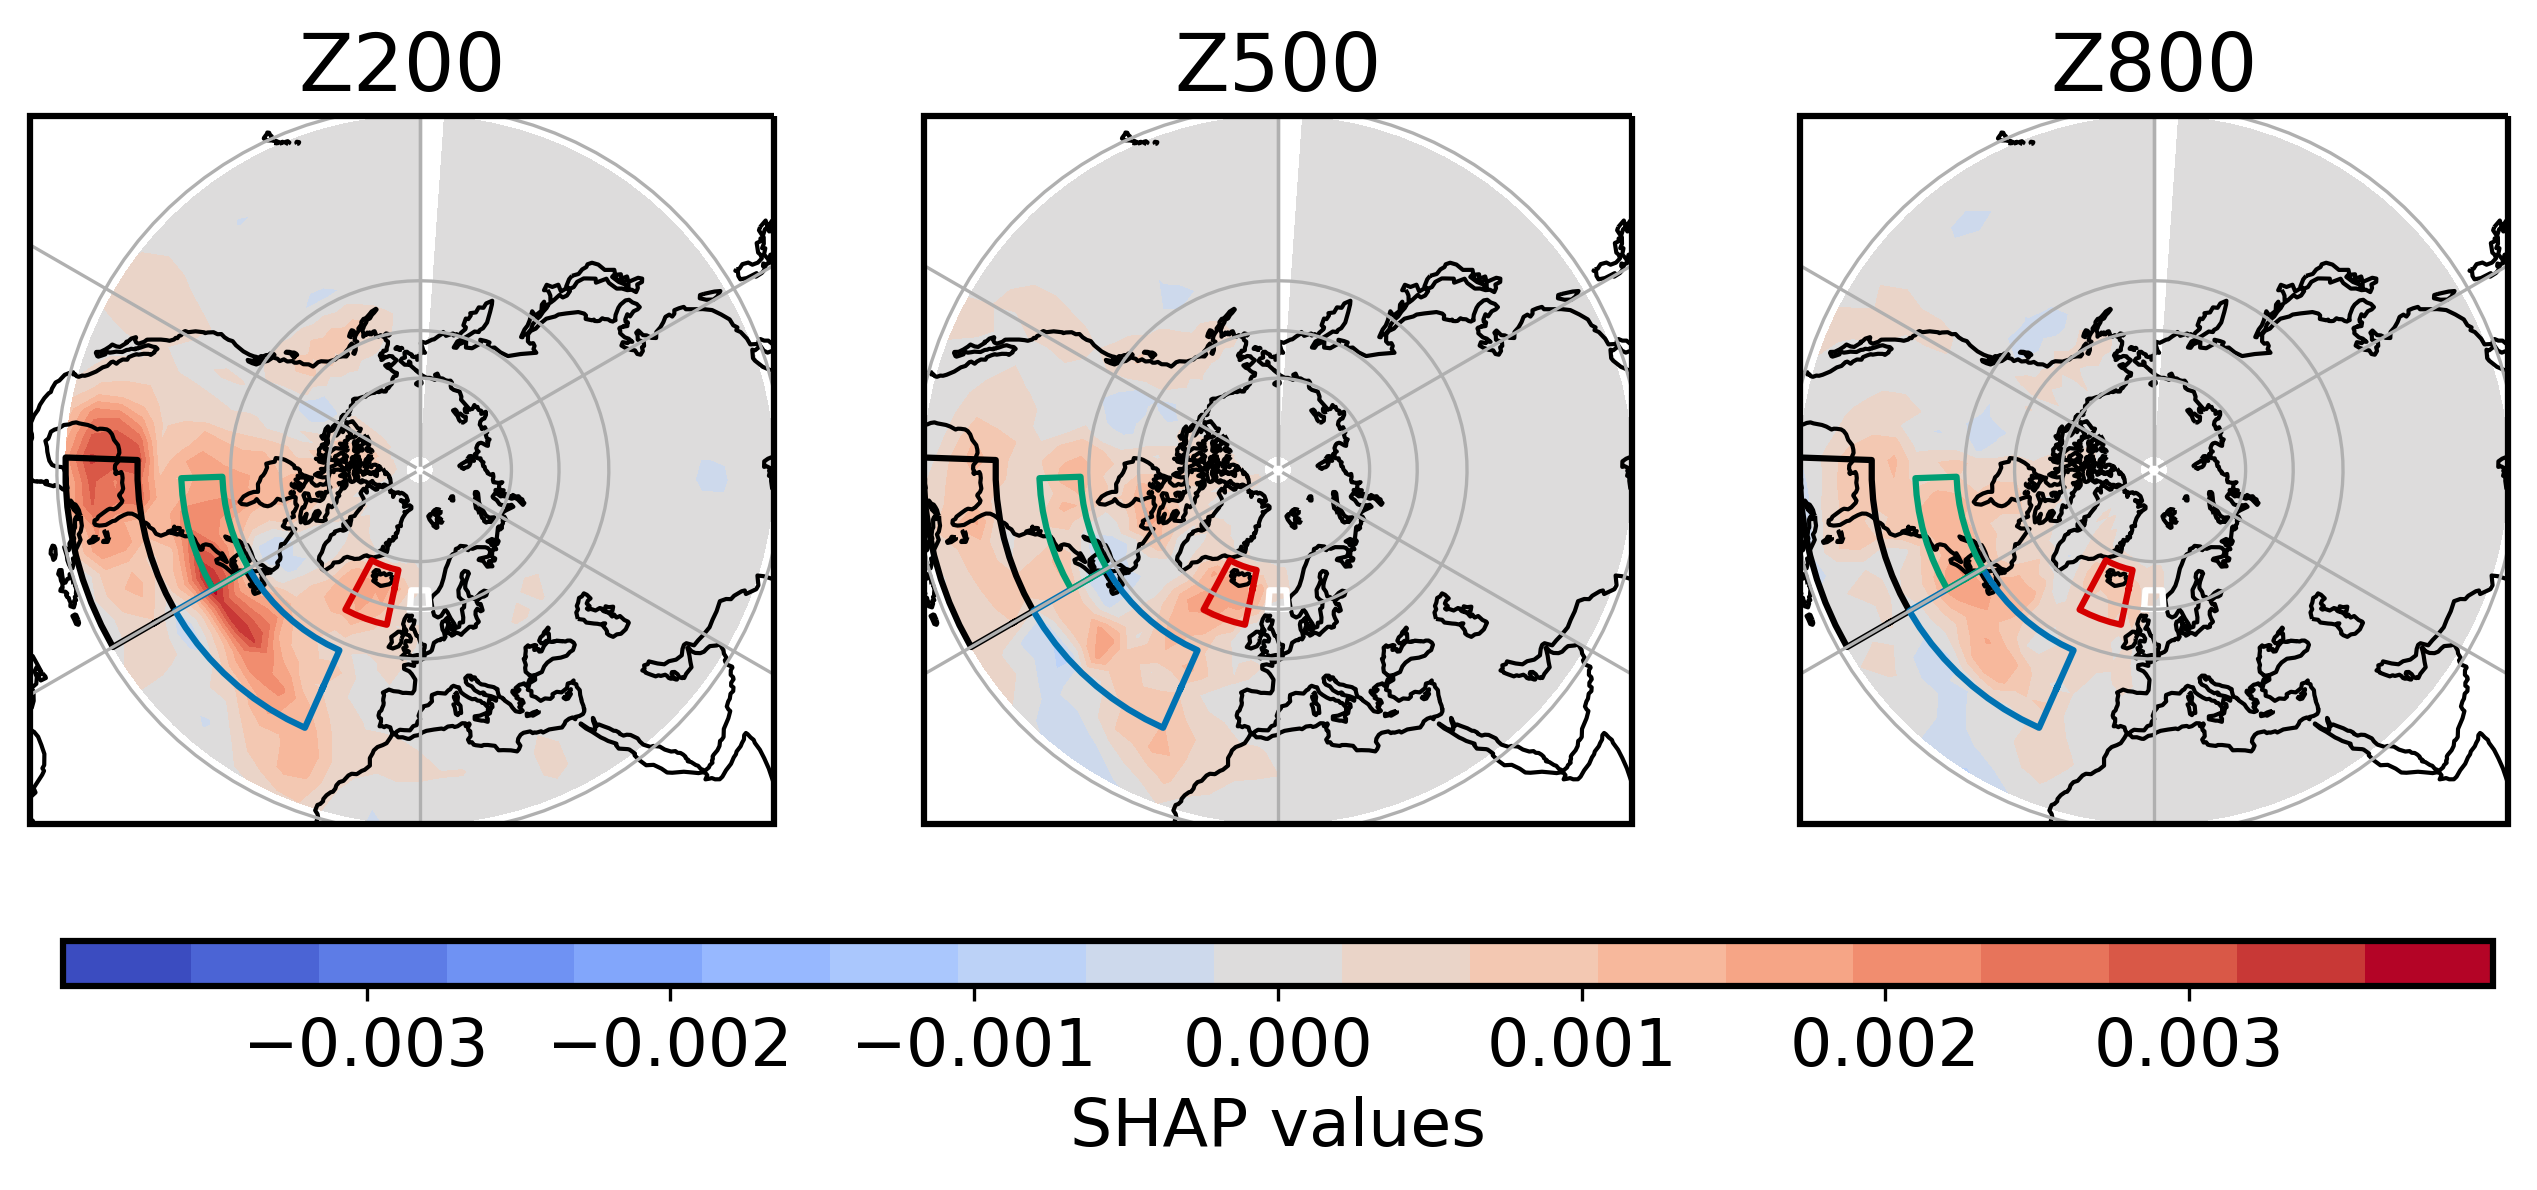

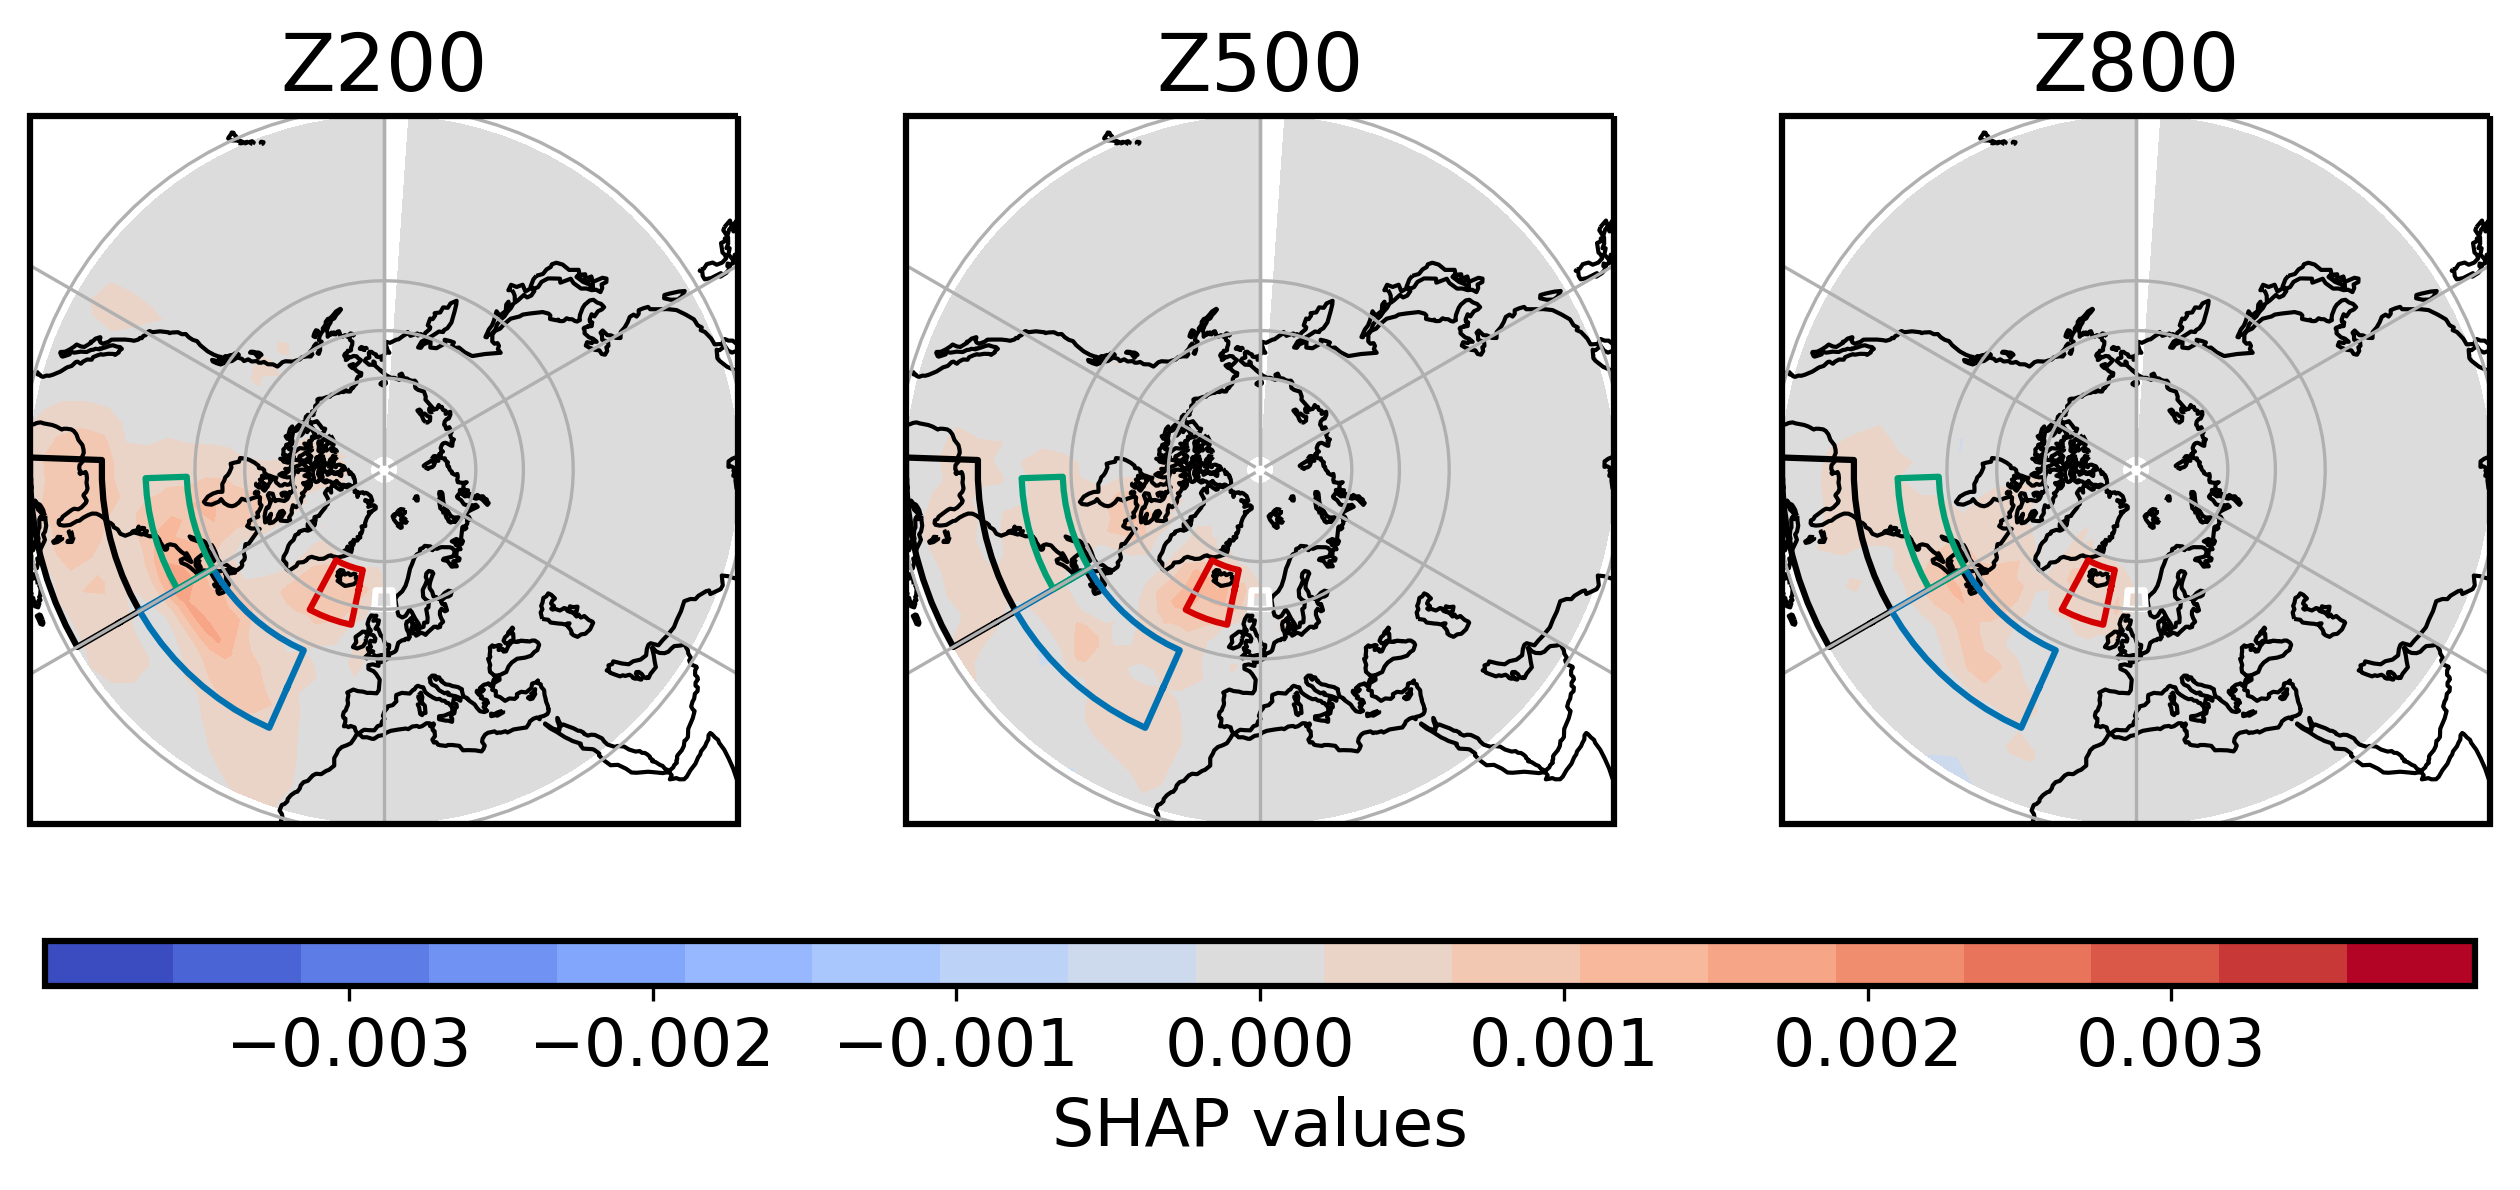

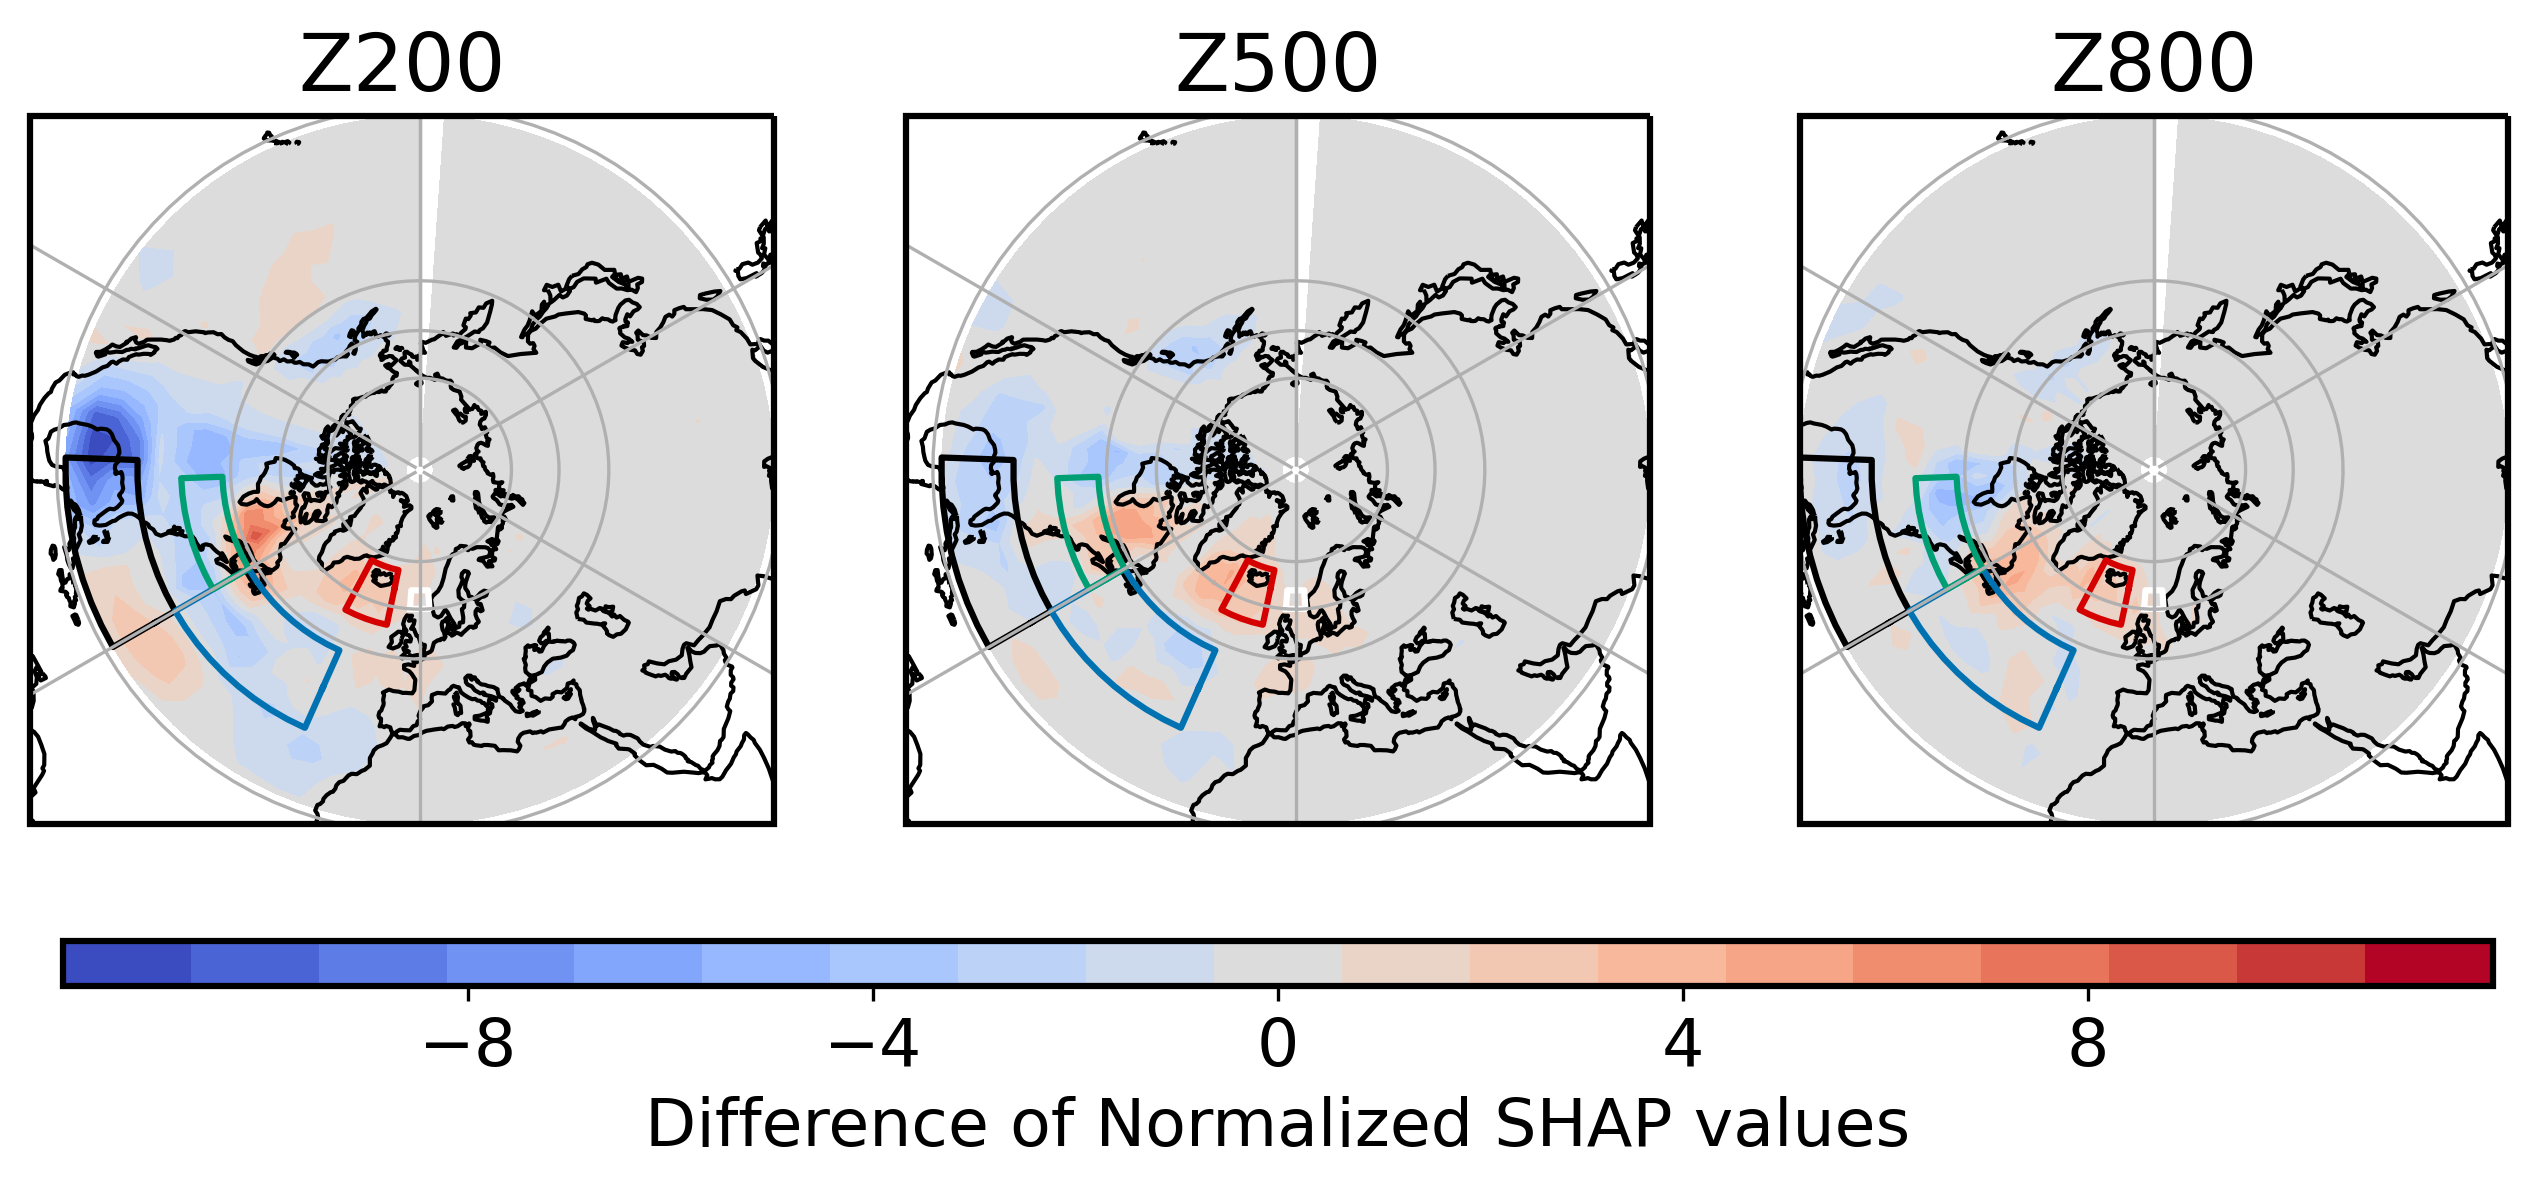

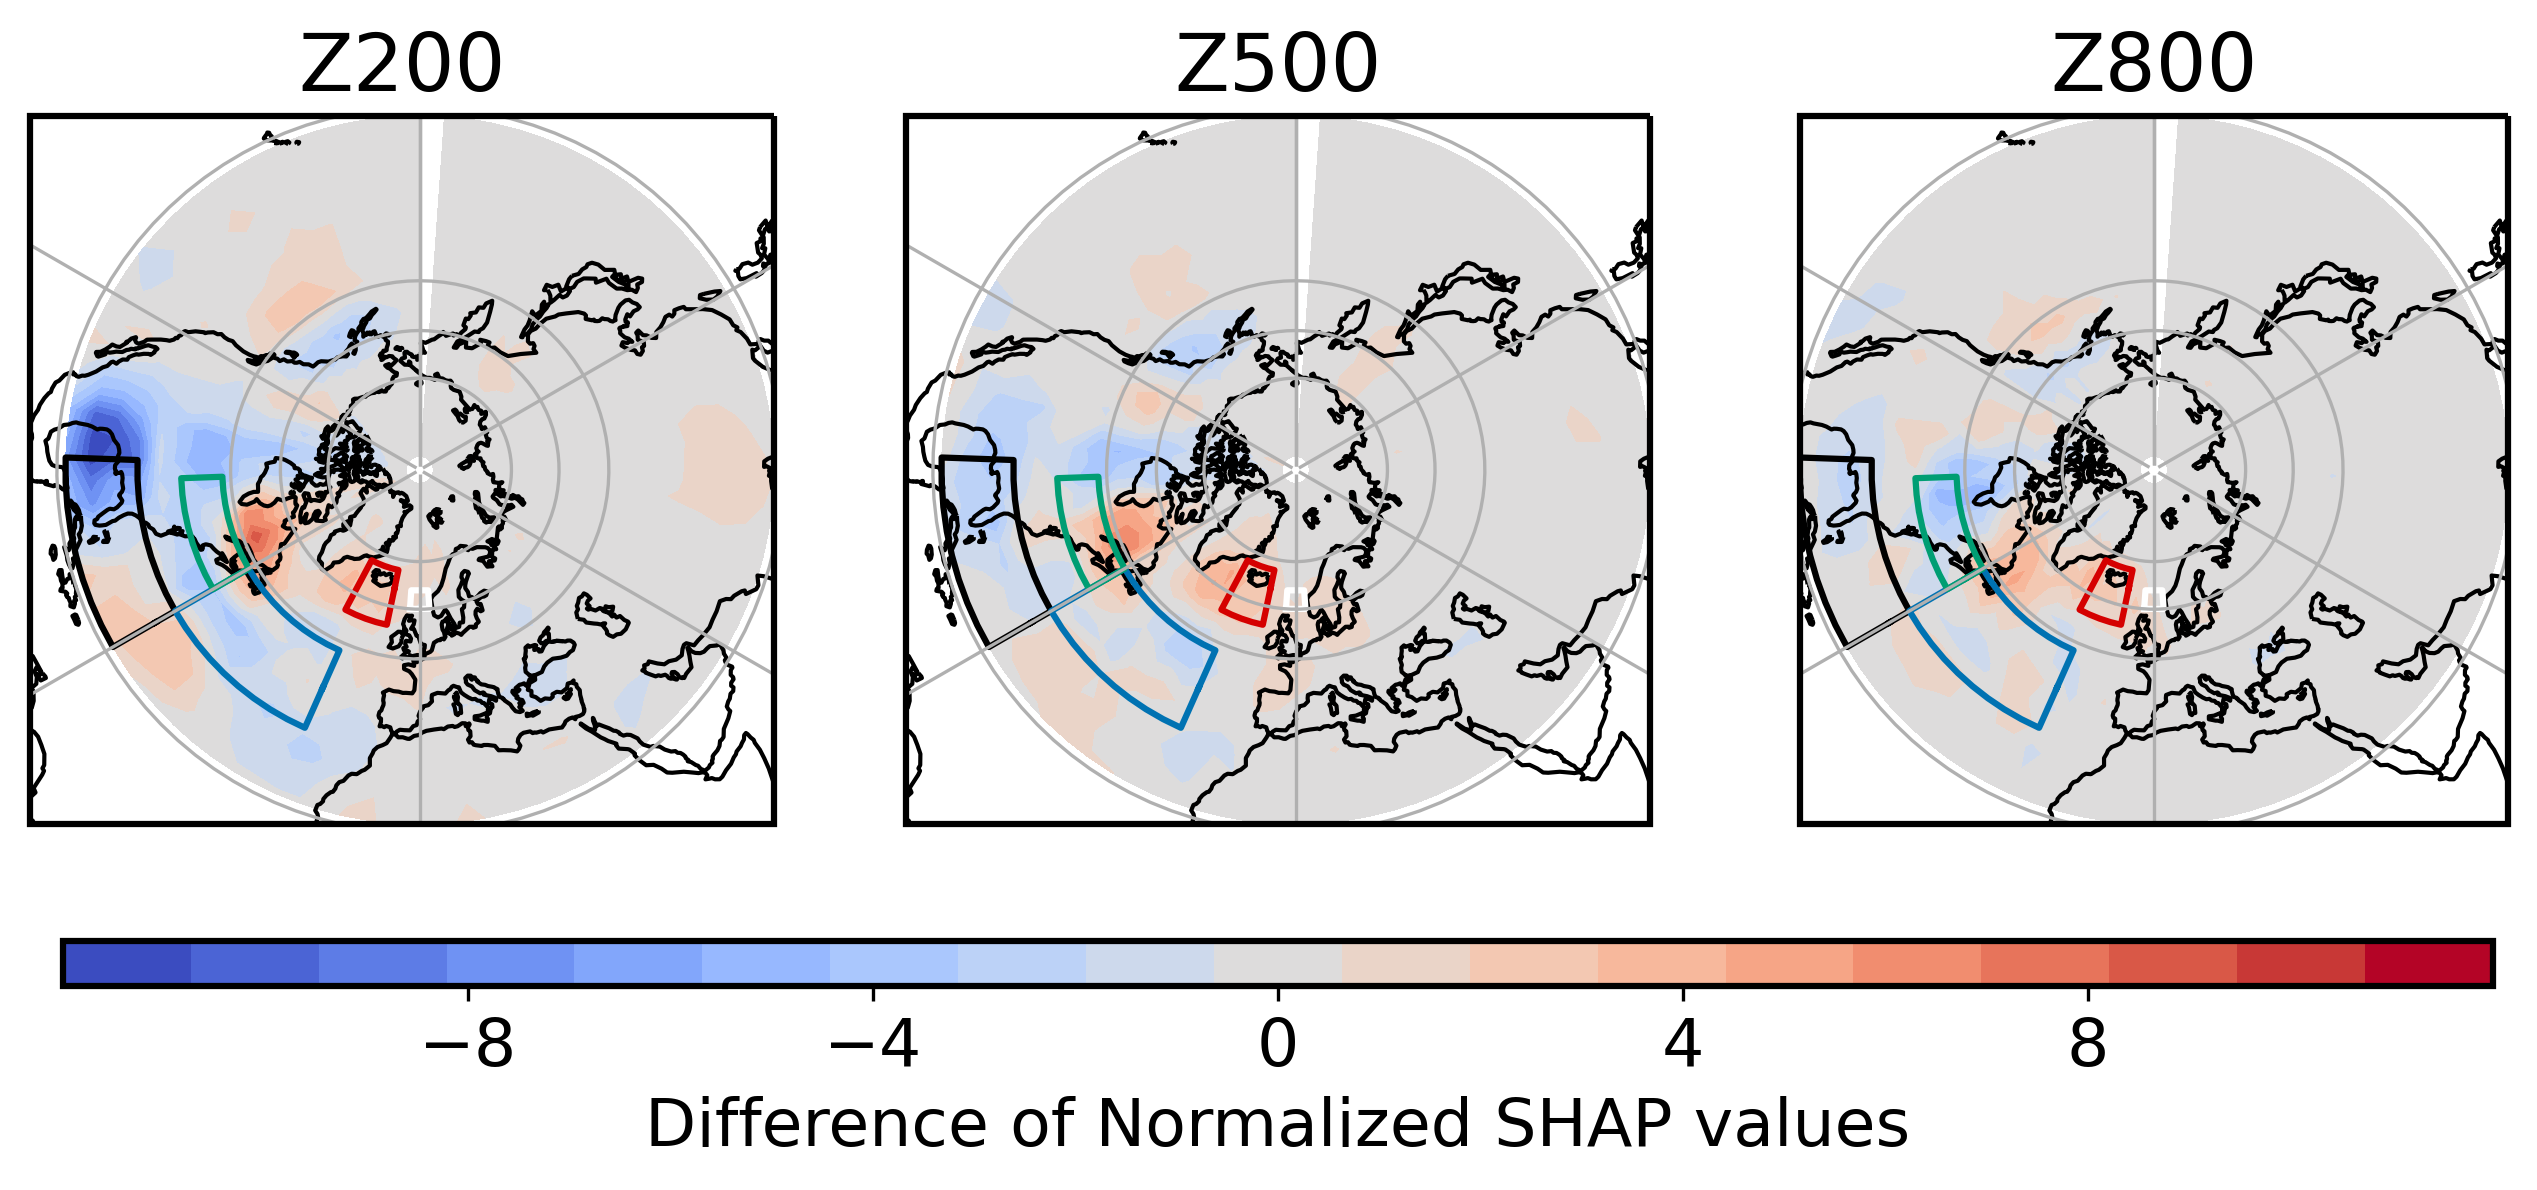

In [4]:
plot1_mean=np.load("shap_before_Fine_tuning.npy")
plot2_mean= np.load("shap_after_Fine_tuning.npy")

plot3=np.load("normalized_shap_difference_max.npy")
plot3_2=np.load("normalized_shap_difference.npy")

plot1_mean=np.load("shap_before_Fine_tuning.npy")
plot2_mean= np.load("shap_after_Fine_tuning.npy")

plot3=np.load("normalized_shap_difference_max.npy")
plot3_2=np.load("normalized_shap_difference.npy")
fig1,ax1=polorplot_levels(plot1_mean,latitudes,longitudes  ,minval=-0.001,maxval=0.004,number_levels=20,iv=0.001)

fig2,ax2=polorplot_levels(plot2_mean,latitudes,longitudes  ,minval=-0.001,maxval=0.004,number_levels=20,iv=0.001)

fig3,ax3=polorplot_levels(plot3,latitudes,longitudes ,\
                         label="Difference of Normalized SHAP values" ,minval=-12,maxval=10,number_levels=20,iv=4)

fig3_2,ax3_2=polorplot_levels(plot3_2,latitudes,longitudes ,\
                         label="Difference of Normalized SHAP values" ,minval=-12,maxval=10,number_levels=20,iv=4)

lon_atl=[]
lat_atl=[]
lat_atl=[latitudes[10],latitudes[10],latitudes[11],latitudes[11],latitudes[10]]
lon_atl=[longitudes[44],longitudes[46],longitudes[46],longitudes[44],longitudes[44]]
for ax in [ax1,ax2,ax3,ax3_2]:
    ax=ax.flatten()
    for a in ax:
        a.plot(lon_atl, lat_atl,'w',linestyle='-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
        
sq=True
str_sq=sq*"_sq"
for ax in [ax1,ax2,ax3,ax3_2]:
    ax=add_sq(sq,ax)
   
fig1.savefig('Fig12_before_Fine_tuning'+str_sq+'.png',dpi=300, bbox_inches="tight" )
fig2.savefig('Fig12_after_Fine_tuning'+str_sq+'.png',dpi=300, bbox_inches="tight" )
fig3.savefig('Fig12_difference'+str_sq+'.png',dpi=300, bbox_inches="tight" )